Loading data from Parts 1 & 2...
Data loaded successfully!
Training data: 179 months
Assets: 17
=== Starting Agent Training Pipeline ===
Environment initialized with 179 time steps
Environment initialized with 179 time steps
Environments created

=== Step 1: Base Agent Training ===
Training base RL agents...

--- Training Data-Driven Agents ---

Training PPO on quantitative data...
  Seed 1/2
Environment initialized with 179 time steps
    Average reward: -0.1671
  Seed 2/2
Environment initialized with 179 time steps
    Average reward: -0.2649

Training SAC on quantitative data...
  Seed 1/2
Environment initialized with 179 time steps
    Average reward: -0.2081
  Seed 2/2
Environment initialized with 179 time steps
    Average reward: -0.2815

--- Training NLP-Based Agents ---

Training PPO on sentiment data...
  Seed 1/2
Environment initialized with 179 time steps
    Average reward: -0.2311
  Seed 2/2
Environment initialized with 179 time steps
    Average reward: -0.1628

Training

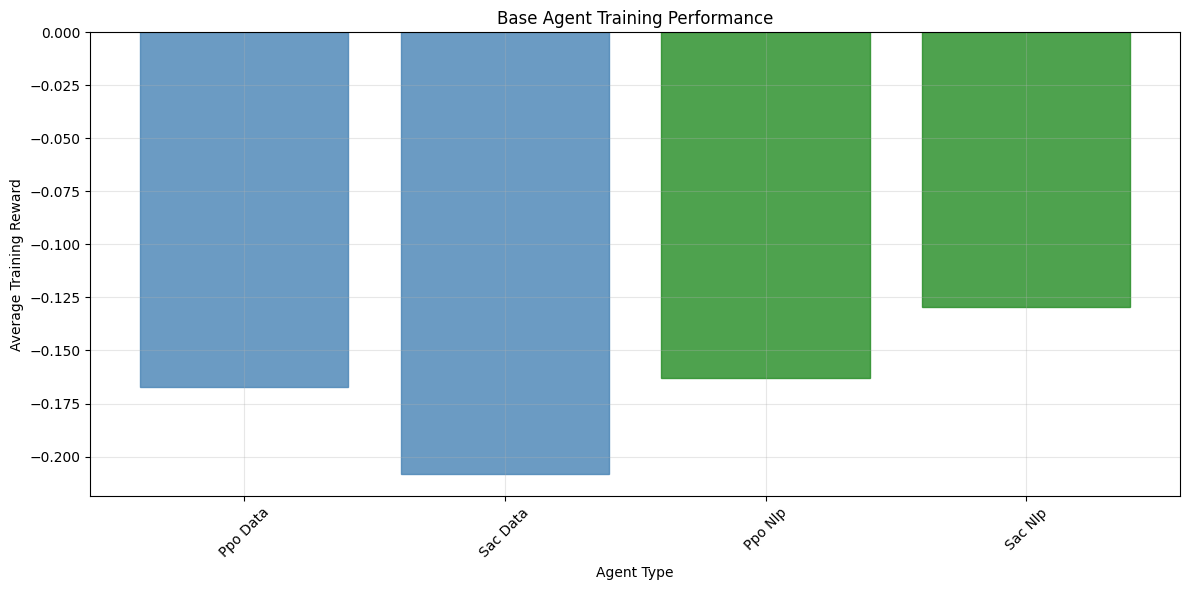

Saving trained models...
Saving base agents...
  Saved PPO_data
  Saved SAC_data
  Saved PPO_nlp
  Saved SAC_nlp
Models saved successfully!

Files created:
- base_agent_*.zip (individual SB3 agent files)
- base_agent_names.pkl
- meta_agent_data.pth
- meta_agent_nlp.pth
- super_agent.pth
- model_info.pkl
- model_classes.pkl

Ready for notebook 04_backtesting_results.ipynb


In [1]:
# HARLF Implementation - Part 3: Agent Training (Base Agents & Meta-Agents)
# Convert this to .ipynb format

# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import PPO, SAC, DDPG, TD3
from stable_baselines3.common.env_util import DummyVecEnv
import gymnasium as gym
from gymnasium import spaces
import pickle
import dill

# Load data from previous notebooks
print("Loading data from Parts 1 & 2...")

# Load processed data
monthly_prices = pd.read_pickle('outputs/monthly_prices.pkl')
train_prices = pd.read_pickle('outputs/train_prices.pkl')
test_prices = pd.read_pickle('outputs/test_prices.pkl')
train_features = pd.read_pickle('outputs/train_features.pkl')
test_features = pd.read_pickle('outputs/test_features.pkl')


train_sentiment = pd.read_pickle('outputs/train_sentiment.pkl')
test_sentiment = pd.read_pickle('outputs/test_sentiment.pkl')


# Load environment class and create a wrapper for stable-baselines3 compatibility
with open('outputs/environment_class.pkl', 'rb') as f:
    HARLFPortfolioEnv = dill.load(f)

# Create a wrapper class that ensures compatibility with stable-baselines3
class SB3CompatibleEnv(gym.Env):
    """Wrapper to ensure stable-baselines3 compatibility"""
    
    def __init__(self, price_data, features, sentiment_features=None, train_period=True):
        super().__init__()
        
        # Create the underlying HARLF environment
        self.harlf_env = HARLFPortfolioEnv(price_data, features, sentiment_features, train_period)
        
        # Copy the action and observation spaces
        self.action_space = self.harlf_env.action_space
        self.observation_space = self.harlf_env.observation_space
        
        # Ensure metadata exists
        self.metadata = {'render.modes': []}
        
        # Copy other important attributes
        self.price_data = price_data
        self.features = features
        self.sentiment_features = sentiment_features
        self.train_period = train_period
    
    def reset(self, seed=None, options=None):
        """Reset with proper return format for newer gym versions"""
        if seed is not None:
            np.random.seed(seed)
        obs = self.harlf_env.reset(seed)
        if isinstance(obs, tuple):
            return obs
        return obs, {}
    
    def step(self, action):
        """Step with proper return format"""
        result = self.harlf_env.step(action)
        if len(result) == 5:
            return result  # Already in new format
        elif len(result) == 4:
            obs, reward, done, info = result
            return obs, reward, done, False, info  # Add truncated flag
        return result
    
    def render(self, mode='human'):
        """Render method (optional)"""
        pass
    
    def close(self):
        """Close method (optional)"""
        pass

with open('outputs/assets.pkl', 'rb') as f:
    ASSETS = pickle.load(f)

print("Data loaded successfully!")
print(f"Training data: {len(train_prices)} months")
print(f"Assets: {len(ASSETS)}")

# Cell 2: Base Agent Training Functions
def train_base_agents(env_data, env_nlp, algorithms=['PPO', 'SAC'], 
                      total_timesteps=10000, n_seeds=2):
    """
    Train base RL agents using Stable Baselines 3
    Reduced parameters for faster execution
    """
    print("Training base RL agents...")
    
    base_agents = {}
    training_results = {}
    
    # Train data-driven agents
    print("\n--- Training Data-Driven Agents ---")
    for algo_name in algorithms:
        print(f"\nTraining {algo_name} on quantitative data...")
        
        algo_agents = []
        algo_results = []
        
        for seed in range(n_seeds):
            print(f"  Seed {seed + 1}/{n_seeds}")
            
            # Create vectorized environment with proper factory function
            def make_env():
                return SB3CompatibleEnv(env_data.price_data, env_data.features, 
                                      env_data.sentiment_features, env_data.train_period)
            vec_env = DummyVecEnv([make_env])
            
            # Initialize agent
            if algo_name == 'PPO':
                agent = PPO('MlpPolicy', vec_env, verbose=0, seed=seed,
                           learning_rate=3e-4, n_steps=2048, batch_size=64)
            elif algo_name == 'SAC':
                agent = SAC('MlpPolicy', vec_env, verbose=0, seed=seed,
                           learning_rate=3e-4, buffer_size=100000, batch_size=256)
            elif algo_name == 'DDPG':
                agent = DDPG('MlpPolicy', vec_env, verbose=0, seed=seed,
                            learning_rate=1e-3, buffer_size=100000, batch_size=128)
            elif algo_name == 'TD3':
                agent = TD3('MlpPolicy', vec_env, verbose=0, seed=seed,
                           learning_rate=1e-3, buffer_size=100000, batch_size=128)
            
            # Train agent
            agent.learn(total_timesteps=total_timesteps)
            
            # Evaluate agent
            obs = vec_env.reset()
            episode_rewards = []
            for _ in range(50):  # Reduced evaluation steps
                action, _ = agent.predict(obs, deterministic=True)
                obs, reward, done, info = vec_env.step(action)
                episode_rewards.append(reward[0])
                if done[0]:
                    obs = vec_env.reset()
            
            avg_reward = np.mean(episode_rewards)
            algo_agents.append(agent)
            algo_results.append(avg_reward)
            
            print(f"    Average reward: {avg_reward:.4f}")
        
        # Store best agent based on median performance
        best_idx = np.argsort(algo_results)[len(algo_results)//2]
        base_agents[f'{algo_name}_data'] = algo_agents[best_idx]
        training_results[f'{algo_name}_data'] = algo_results[best_idx]
    
    # Train NLP-based agents
    if env_nlp is not None:
        print("\n--- Training NLP-Based Agents ---")
        for algo_name in algorithms:
            print(f"\nTraining {algo_name} on sentiment data...")
            
            algo_agents = []
            algo_results = []
            
            for seed in range(n_seeds):
                print(f"  Seed {seed + 1}/{n_seeds}")
                
                # Create vectorized environment with proper factory function
                def make_nlp_env():
                    return SB3CompatibleEnv(env_nlp.price_data, env_nlp.features, 
                                          env_nlp.sentiment_features, env_nlp.train_period)
                vec_env = DummyVecEnv([make_nlp_env])
                
                # Initialize agent (same parameters as data agents)
                if algo_name == 'PPO':
                    agent = PPO('MlpPolicy', vec_env, verbose=0, seed=seed,
                               learning_rate=3e-4, n_steps=2048, batch_size=64)
                elif algo_name == 'SAC':
                    agent = SAC('MlpPolicy', vec_env, verbose=0, seed=seed,
                               learning_rate=3e-4, buffer_size=100000, batch_size=256)
                elif algo_name == 'DDPG':
                    agent = DDPG('MlpPolicy', vec_env, verbose=0, seed=seed,
                                learning_rate=1e-3, buffer_size=100000, batch_size=128)
                elif algo_name == 'TD3':
                    agent = TD3('MlpPolicy', vec_env, verbose=0, seed=seed,
                               learning_rate=1e-3, buffer_size=100000, batch_size=128)
                
                # Train agent
                agent.learn(total_timesteps=total_timesteps)
                
                # Evaluate agent
                obs = vec_env.reset()
                episode_rewards = []
                for _ in range(50):
                    action, _ = agent.predict(obs, deterministic=True)
                    obs, reward, done, info = vec_env.step(action)
                    episode_rewards.append(reward[0])
                    if done[0]:
                        obs = vec_env.reset()
                
                avg_reward = np.mean(episode_rewards)
                algo_agents.append(agent)
                algo_results.append(avg_reward)
                
                print(f"    Average reward: {avg_reward:.4f}")
            
            # Store best agent
            best_idx = np.argsort(algo_results)[len(algo_results)//2]
            base_agents[f'{algo_name}_nlp'] = algo_agents[best_idx]
            training_results[f'{algo_name}_nlp'] = algo_results[best_idx]
    
    print("\n--- Base Agent Training Complete ---")
    print("Training Results:")
    for agent_name, result in training_results.items():
        print(f"  {agent_name}: {result:.4f}")
    
    return base_agents, training_results

# Cell 3: Meta-Agent Classes
class MetaAgent(nn.Module):
    """
    Meta-Agent implementation using PyTorch
    Equation (1) from the HARLF paper
    """
    
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(MetaAgent, self).__init__()
        
        # Three-layer fully connected network with ReLU activations
        self.W1 = nn.Linear(input_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.W3 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize network weights"""
        for layer in [self.W1, self.W2, self.W3]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        """
        Forward pass implementing Equation (1):
        f_θ(X_t) = Softmax(W3 · ReLU(W2 · ReLU(W1 · X_t + b1) + b2) + b3)
        """
        # First layer with ReLU
        h1 = torch.relu(self.W1(x))
        
        # Second layer with ReLU  
        h2 = torch.relu(self.W2(h1))
        
        # Output layer with Softmax (ensures weights sum to 1)
        output = torch.softmax(self.W3(h2), dim=-1)
        
        return output

class SuperAgent(nn.Module):
    """
    Super-Agent that combines meta-agent outputs
    Final layer of the HARLF hierarchy
    """
    
    def __init__(self, n_assets, hidden_dim=64):
        super(SuperAgent, self).__init__()
        
        # Input: concatenated outputs from data and NLP meta-agents
        input_dim = n_assets * 2  # Two meta-agent outputs
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, n_assets),
            nn.Softmax(dim=-1)  # Ensure portfolio weights sum to 1
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize network weights"""
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, meta_data_output, meta_nlp_output):
        """
        Combine meta-agent outputs to produce final allocation
        """
        # Concatenate meta-agent outputs
        combined_input = torch.cat([meta_data_output, meta_nlp_output], dim=-1)
        
        # Forward pass through network
        final_allocation = self.network(combined_input)
        
        return final_allocation

# Cell 4: Meta-Agent Training Functions
def collect_base_agent_predictions(base_agents, env_data, env_nlp, n_episodes=20):
    """
    Collect predictions from base agents for meta-agent training
    Reduced episodes for faster execution
    """
    print("Collecting base agent predictions...")
    
    data_predictions = []
    nlp_predictions = []
    targets = []
    
    # Collect from data agents
    data_agent_names = [name for name in base_agents.keys() if 'data' in name]
    
    for episode in range(n_episodes):
        # Reset environments - unpack the tuple
        obs_data, _ = env_data.reset()
        obs_nlp, _ = env_nlp.reset() if env_nlp else (None, None)
        
        episode_data_preds = []
        episode_nlp_preds = []
        episode_targets = []
        
        done = False
        step_count = 0
        max_steps = 50  # Limit steps per episode
        
        while not done and step_count < max_steps:
            # Get predictions from data agents
            data_agent_preds = []
            for agent_name in data_agent_names:
                agent = base_agents[agent_name]
                action, _ = agent.predict(obs_data, deterministic=True)
                data_agent_preds.append(action)
            
            # Get predictions from NLP agents
            nlp_agent_preds = []
            if obs_nlp is not None:
                nlp_agent_names = [name for name in base_agents.keys() if 'nlp' in name]
                for agent_name in nlp_agent_names:
                    agent = base_agents[agent_name]
                    action, _ = agent.predict(obs_nlp, deterministic=True)
                    nlp_agent_preds.append(action)
            
            # Store predictions
            if data_agent_preds:
                episode_data_preds.append(np.concatenate(data_agent_preds))
            if nlp_agent_preds:
                episode_nlp_preds.append(np.concatenate(nlp_agent_preds))
            
            # Calculate optimal target (use best performing agent's action)
            best_action = data_agent_preds[0] if data_agent_preds else nlp_agent_preds[0]
            episode_targets.append(best_action)
            
            # Step environments - handle 5 return values (obs, reward, terminated, truncated, info)
            obs_data, _, terminated, truncated, _ = env_data.step(best_action)
            done = terminated or truncated
            if env_nlp:
                obs_nlp, _, _, _, _ = env_nlp.step(best_action)
            
            step_count += 1
        
        # Aggregate episode predictions
        if episode_data_preds:
            data_predictions.extend(episode_data_preds)
        if episode_nlp_preds:
            nlp_predictions.extend(episode_nlp_preds)
        targets.extend(episode_targets)
    
    return np.array(data_predictions), np.array(nlp_predictions), np.array(targets)

def train_meta_agents(data_predictions, nlp_predictions, targets, n_assets, 
                      epochs=200, learning_rate=0.001):
    """
    Train meta-agents using collected base agent predictions
    Reduced epochs for faster execution
    """
    print("Training meta-agents...")
    
    # Prepare data
    data_input_dim = data_predictions.shape[1] if len(data_predictions) > 0 else n_assets * 2
    nlp_input_dim = nlp_predictions.shape[1] if len(nlp_predictions) > 0 else n_assets * 2
    
    # Initialize meta-agents
    meta_agent_data = MetaAgent(data_input_dim, n_assets)
    meta_agent_nlp = MetaAgent(nlp_input_dim, n_assets)
    
    # Optimizers
    optimizer_data = optim.Adam(meta_agent_data.parameters(), lr=learning_rate)
    optimizer_nlp = optim.Adam(meta_agent_nlp.parameters(), lr=learning_rate)
    
    # Loss function
    criterion = nn.MSELoss()
    
    # Convert to tensors
    if len(data_predictions) > 0:
        data_tensor = torch.FloatTensor(data_predictions)
        target_tensor = torch.FloatTensor(targets[:len(data_predictions)])
        
        # Training loop for data meta-agent
        print("Training data meta-agent...")
        for epoch in range(epochs):
            optimizer_data.zero_grad()
            
            outputs = meta_agent_data(data_tensor)
            loss = criterion(outputs, target_tensor)
            
            loss.backward()
            optimizer_data.step()
            
            if epoch % 50 == 0:
                print(f"  Data meta-agent epoch {epoch}, Loss: {loss.item():.4f}")
    
    if len(nlp_predictions) > 0:
        nlp_tensor = torch.FloatTensor(nlp_predictions)
        target_tensor = torch.FloatTensor(targets[:len(nlp_predictions)])
        
        # Training loop for NLP meta-agent
        print("Training NLP meta-agent...")
        for epoch in range(epochs):
            optimizer_nlp.zero_grad()
            
            outputs = meta_agent_nlp(nlp_tensor)
            loss = criterion(outputs, target_tensor)
            
            loss.backward()
            optimizer_nlp.step()
            
            if epoch % 50 == 0:
                print(f"  NLP meta-agent epoch {epoch}, Loss: {loss.item():.4f}")
    
    return meta_agent_data, meta_agent_nlp

def train_super_agent(meta_agent_data, meta_agent_nlp, base_agents, env_data, env_nlp,
                      n_assets, epochs=100, learning_rate=0.001):
    """
    Train super-agent using Algorithm 2 from the paper
    Reduced epochs for faster execution
    """
    print("Training super-agent...")
    
    # Initialize super-agent
    super_agent = SuperAgent(n_assets)
    optimizer = optim.Adam(super_agent.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Collect training data
    training_data = []
    
    for episode in range(50):  # Reduced training episodes
        obs_data, _ = env_data.reset()
        obs_nlp, _ = env_nlp.reset() if env_nlp else (obs_data, {})
        
        done = False
        step_count = 0
        max_steps = 30  # Limit steps per episode
        
        while not done and step_count < max_steps:
            # Get base agent predictions
            data_agent_names = [name for name in base_agents.keys() if 'data' in name]
            nlp_agent_names = [name for name in base_agents.keys() if 'nlp' in name]
            
            # Collect data agent predictions
            data_preds = []
            for agent_name in data_agent_names:
                action, _ = base_agents[agent_name].predict(obs_data, deterministic=True)
                data_preds.append(action)
            
            # Collect NLP agent predictions
            nlp_preds = []
            if nlp_agent_names and env_nlp:
                for agent_name in nlp_agent_names:
                    action, _ = base_agents[agent_name].predict(obs_nlp, deterministic=True)
                    nlp_preds.append(action)
            else:
                nlp_preds = data_preds  # Fallback
            
            # Get meta-agent outputs
            if data_preds:
                data_input = torch.FloatTensor(np.concatenate(data_preds)).unsqueeze(0)
                meta_data_output = meta_agent_data(data_input)
            else:
                meta_data_output = torch.ones(1, n_assets) / n_assets
            
            if nlp_preds:
                nlp_input = torch.FloatTensor(np.concatenate(nlp_preds)).unsqueeze(0)
                meta_nlp_output = meta_agent_nlp(nlp_input)
            else:
                meta_nlp_output = torch.ones(1, n_assets) / n_assets
            
            # Store training sample
            training_data.append({
                'meta_data': meta_data_output.detach(),
                'meta_nlp': meta_nlp_output.detach(),
                'target': torch.FloatTensor(data_preds[0] if data_preds else nlp_preds[0]).unsqueeze(0)
            })
            
            # Step environment
            action = data_preds[0] if data_preds else nlp_preds[0] 
            obs_data, _, terminated, truncated, _ = env_data.step(action)
            done = terminated or truncated
            if env_nlp:
                obs_nlp, _, _, _, _ = env_nlp.step(action)
            
            step_count += 1
    
    # Training loop
    print(f"Training super-agent with {len(training_data)} samples...")
    
    for epoch in range(epochs):
        total_loss = 0
        np.random.shuffle(training_data)
        
        for sample in training_data:
            optimizer.zero_grad()
            
            # Forward pass
            output = super_agent(sample['meta_data'], sample['meta_nlp'])
            loss = criterion(output, sample['target'])
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if epoch % 25 == 0:
            avg_loss = total_loss / len(training_data)
            print(f"  Super-agent epoch {epoch}, Average Loss: {avg_loss:.4f}")
    
    return super_agent

# Cell 5: Execute Training Pipeline
print("=== Starting Agent Training Pipeline ===")

# Create environments using the compatible wrapper
env_data = SB3CompatibleEnv(train_prices, train_features, train_period=True)
env_nlp = SB3CompatibleEnv(train_prices, train_sentiment, train_period=True) if train_sentiment is not None else None

print("Environments created")

# Step 1: Train base agents
print("\n=== Step 1: Base Agent Training ===")
base_agents, training_results = train_base_agents(
    env_data, env_nlp, 
    algorithms=['PPO', 'SAC'],  # Reduced for faster execution
    total_timesteps=10000,      # Reduced for faster execution
    n_seeds=2                   # Reduced for faster execution
)

# Step 2: Collect base agent predictions for meta-training
print("\n=== Step 2: Collecting Base Agent Predictions ===")
data_preds, nlp_preds, targets = collect_base_agent_predictions(
    base_agents, env_data, env_nlp, n_episodes=20  # Reduced for faster execution
)

# Step 3: Train meta-agents
print("\n=== Step 3: Meta-Agent Training ===")
n_assets = len(train_prices.columns)
meta_agent_data, meta_agent_nlp = train_meta_agents(
    data_preds, nlp_preds, targets, n_assets,
    epochs=200,  # Reduced for faster execution
    learning_rate=0.001
)

# Step 4: Train super-agent
print("\n=== Step 4: Super-Agent Training ===")
super_agent = train_super_agent(
    meta_agent_data, meta_agent_nlp, base_agents,
    env_data, env_nlp, n_assets,
    epochs=100,  # Reduced for faster execution
    learning_rate=0.001
)

print("\n=== Agent Training Complete ===")

# Cell 6: Visualization - Training Results
plt.figure(figsize=(12, 6))

# Plot training results
agent_names = list(training_results.keys())
rewards = list(training_results.values())

# Separate data and NLP agents
data_agents = [name for name in agent_names if 'data' in name]
nlp_agents = [name for name in agent_names if 'nlp' in name]

x_pos = np.arange(len(agent_names))
bars = plt.bar(x_pos, rewards, alpha=0.8)

# Color code: blue for data, green for NLP
for i, bar in enumerate(bars):
    if 'data' in agent_names[i]:
        bar.set_color('steelblue')
    else:
        bar.set_color('forestgreen')

plt.xlabel('Agent Type')
plt.ylabel('Average Training Reward')
plt.title('Base Agent Training Performance')
plt.xticks(x_pos, [name.replace('_', ' ').title() for name in agent_names], rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cell 7: Save Trained Models
print("Saving trained models...")

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save base agents using SB3's built-in save method
print("Saving base agents...")
for agent_name, agent in base_agents.items():
    agent.save(f'models/base_agent_{agent_name}')
    print(f"  Saved {agent_name}")

# Save agent names for later loading
with open('models/base_agent_names.pkl', 'wb') as f:
    pickle.dump(list(base_agents.keys()), f)

# Save meta-agents
torch.save(meta_agent_data.state_dict(), 'models/meta_agent_data.pth')
torch.save(meta_agent_nlp.state_dict(), 'models/meta_agent_nlp.pth')

# Save super-agent
torch.save(super_agent.state_dict(), 'models/super_agent.pth')

# Save model architectures
model_info = {
    'n_assets': n_assets,
    'data_input_dim': data_preds.shape[1] if len(data_preds) > 0 else n_assets * 2,
    'nlp_input_dim': nlp_preds.shape[1] if len(nlp_preds) > 0 else n_assets * 2,
}
with open('models/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

# Save model classes
with open('models/model_classes.pkl', 'wb') as f:
    dill.dump({
        'MetaAgent': MetaAgent,
        'SuperAgent': SuperAgent
    }, f)

# Save loading helper function
def load_base_agents():
    """Helper function to load base agents in future notebooks"""
    from stable_baselines3 import PPO, SAC, DDPG, TD3
    import pickle
    
    # Load agent names
    with open('models/base_agent_names.pkl', 'rb') as f:
        agent_names = pickle.load(f)
    
    # Load each agent
    loaded_agents = {}
    for agent_name in agent_names:
        # Determine agent type
        if 'PPO' in agent_name:
            agent = PPO.load(f'models/base_agent_{agent_name}')
        elif 'SAC' in agent_name:
            agent = SAC.load(f'models/base_agent_{agent_name}')
        elif 'DDPG' in agent_name:
            agent = DDPG.load(f'models/base_agent_{agent_name}')
        elif 'TD3' in agent_name:
            agent = TD3.load(f'models/base_agent_{agent_name}')
        
        loaded_agents[agent_name] = agent
    
    return loaded_agents

# Save the loading function
with open('models/load_agents.py', 'w') as f:
    f.write('''def load_base_agents():
    """Helper function to load base agents"""
    from stable_baselines3 import PPO, SAC, DDPG, TD3
    import pickle
    
    # Load agent names
    with open('models/base_agent_names.pkl', 'rb') as f:
        agent_names = pickle.load(f)
    
    # Load each agent
    loaded_agents = {}
    for agent_name in agent_names:
        # Determine agent type
        if 'PPO' in agent_name:
            agent = PPO.load(f'models/base_agent_{agent_name}')
        elif 'SAC' in agent_name:
            agent = SAC.load(f'models/base_agent_{agent_name}')
        elif 'DDPG' in agent_name:
            agent = DDPG.load(f'models/base_agent_{agent_name}')
        elif 'TD3' in agent_name:
            agent = TD3.load(f'models/base_agent_{agent_name}')
        
        loaded_agents[agent_name] = agent
    
    return loaded_agents
''')

print("Models saved successfully!")
print("\nFiles created:")
print("- base_agent_*.zip (individual SB3 agent files)")
print("- base_agent_names.pkl")
print("- meta_agent_data.pth")
print("- meta_agent_nlp.pth")
print("- super_agent.pth")
print("- model_info.pkl")
print("- model_classes.pkl")
print("\nReady for notebook 04_backtesting_results.ipynb")